In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [42]:
df = pd.read_pickle('ResAss_w_PbSch_Rtngs_Clnd_df.p')

In [43]:
df['Zipcode'] = df['ZipCode_reduced'].astype(int)
df.drop('ZipCode_reduced', axis=1, inplace=True)

In [44]:
df['Documentation_YearAge'] = 2017 - df['DocumentDate'].dt.year
df['Documentation_month'] = df['DocumentDate'].dt.month

df.drop(['DocumentDate'], axis=1, inplace=True)

In [45]:
df['TotalCost'] = df['SalePrice'] + df['AddnlCost']

In [46]:
len(df)

71417

In [47]:
def SaleWarning_conv(df):
    df.SaleWarning = df.SaleWarning.apply(lambda x: x.split())
    warningdummies = pd.get_dummies(df.SaleWarning.apply(pd.Series).stack(), prefix='SWarn', drop_first=False).sum(level=0)
    df = df.join(warningdummies, how='left').fillna(0.0)
    df = df.drop('SaleWarning', axis=1)
    return df

In [48]:
df = SaleWarning_conv(df)

In [49]:
def Zipcode_converter(df):
    Zipcode_dummies = pd.get_dummies(df.Zipcode, drop_first=False)
    df = pd.concat([df, Zipcode_dummies], axis=1).drop('Zipcode', axis=1)
    return df

In [50]:
df = Zipcode_converter(df)

In [51]:
def HeatSource_converter(df):
    HeatSource_dummies = pd.get_dummies(df.HeatSource, drop_first=False, prefix='HeatSource')
    df = pd.concat([df, HeatSource_dummies], axis=1).drop('HeatSource', axis=1)
    return df

In [52]:
def HeatSystem_converter(df):
    HeatSystem_dummies = pd.get_dummies(df.HeatSystem, drop_first=False, prefix='HeatSystem')
    df = pd.concat([df, HeatSystem_dummies], axis=1).drop('HeatSystem', axis=1)
    return df

In [53]:
df = HeatSource_converter(df)

In [54]:
df = HeatSystem_converter(df)

In [55]:
df.drop(['Address', 'StreetName', 'StreetType', 'SellerName', 'BuyerName', 'DirectionSuffix', 
         'parcel_number', 'PROP_NAME', 'ES_ZONE', 'MS_ZONE', 'HS_ZONE', 'LEVY_JURIS', 'SalePrice', 
         'AddnlCost', 'ExciseTaxNbr', 'BldgGrade', 'SaleReason', 'SaleInstrument', 'FinBasementGrade'], axis=1, inplace=True)

In [56]:
uplimit = min(df.TotalCost.mean() + df.TotalCost.std()*4, 2000000)
bottomlimit = 100000 # min(abs(df.TotalCost.mean() - df.TotalCost.std()*4), df.TotalCost.min())
print uplimit, bottomlimit

1742930.97514 100000


In [57]:
df = df[(df.TotalCost > bottomlimit) & (df.TotalCost < uplimit)]

In [58]:
df.TotalCost.max(), df.TotalCost.min(), len(df)

(1740000, 100001, 64236)

In [59]:
df.TotalCost.describe()

count    6.423600e+04
mean     3.852686e+05
std      2.524191e+05
min      1.000010e+05
25%      2.000000e+05
50%      3.240000e+05
75%      4.865000e+05
max      1.740000e+06
Name: TotalCost, dtype: float64

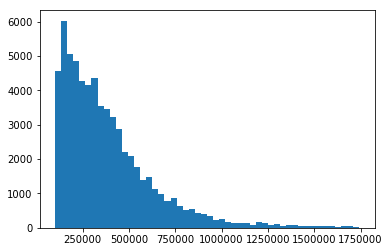

In [60]:
plt.hist(df.TotalCost, bins=50, range=(bottomlimit, uplimit));

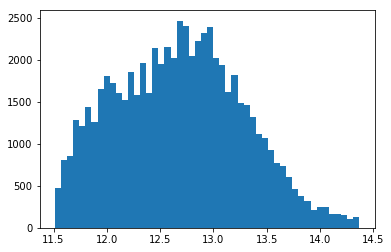

In [61]:
plt.hist(np.log(df.TotalCost), bins=50);

In [62]:
#df1 = df[df.Documentation_YearAge <= 1]
df1 = df

In [63]:
df1.head(15)

,NbrLivingUnits,Stories,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,Condition,DLB_N,DLB_NaN,DLB_Y,HP_N,HP_NaN,HP_Y,AFL_N,AFL_NaN,AFL_Y,ACL_N,ACL_NaN,ACL_Y,VU_N,VU_NaN,VU_Y,LOTSQFT,ES_Ranking,MS_Ranking,HS_Ranking,Documentation_YearAge,Documentation_month,TotalCost,SWarn_*,SWarn_1,SWarn_10,SWarn_11,SWarn_12,SWarn_13,SWarn_14,SWarn_15,SWarn_16,SWarn_17,SWarn_18,SWarn_19,SWarn_2,SWarn_20,SWarn_21,SWarn_22,SWarn_23,SWarn_24,SWarn_26,SWarn_28,SWarn_29,SWarn_3,SWarn_30,SWarn_31,SWarn_32,SWarn_33,SWarn_34,SWarn_35,SWarn_36,SWarn_37,SWarn_38,SWarn_39,SWarn_4,SWarn_40,SWarn_41,SWarn_43,SWarn_44,SWarn_45,SWarn_46,SWarn_48,SWarn_5,SWarn_50,SWarn_51,SWarn_52,SWarn_53,SWarn_54,SWarn_55,SWarn_56,SWarn_57,SWarn_6,SWarn_60,SWarn_7,SWarn_8,SWarn_9,SWarn_92,98102,98103,98104,98105,98106,98107,98108,98109,98112,98115,98116,98117,98118,98119,98122,98125,98126,98133,98136,98144,98146,98177,98178,98199,HeatSource_0,HeatSource_1,HeatSource_2,HeatSource_3,HeatSource_4,HeatSource_5,HeatSource_6,HeatSource_7,HeatSystem_0,HeatSystem_1,HeatSystem_2,HeatSystem_3,HeatSystem_4,HeatSystem_5,HeatSystem_6,HeatSystem_7,HeatSystem_8
0,1,1.0,1030,0,0,0,0,0,1230,920,200,240,0,0,0,240,0,4,0,1,2,0,0,0,0,1977,0,3,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,6000.0,4,8,5,19,12,144950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1.0,1030,0,0,0,0,0,1230,920,200,240,0,0,0,240,0,4,0,1,2,0,0,0,0,1977,0,3,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,6000.0,4,8,5,19,7,137930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,1.0,1350,0,0,0,0,0,1350,430,0,0,0,50,0,0,0,4,0,0,1,1,0,0,0,1900,0,3,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,6000.0,4,8,5,12,8,250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,2.0,1080,0,1080,0,0,0,2700,1080,540,0,0,0,0,750,0,4,0,2,1,0,1,0,1,1954,0,4,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,6050.0,4,8,5,0,5,1210000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,2.0,1080,0,1080,0,0,0,2700,1080,540,0,0,0,0,750,0,4,0,2,1,0,1,0,1,1954,0,4,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,6050.0,4,8,5,9,7,790500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,1,2.0,1080,0,1080,0,0,0,2700,1080,540,0,0,0,0,750,0,4,0,2,1,0,1,0,1,1954,0,4,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,6050.0,4,8,5,22,12,225000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,

In [64]:
len(df1)

64236

In [65]:
y = df1.TotalCost
X = df1.drop('TotalCost', axis=1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [67]:
FSM1 = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=0)
FSM1.fit(X_train, y_train)
y_predict1 = FSM1.predict(X_test).astype(int)
y_true = y_test.as_matrix()
FSM1.score(X_test, y_test)

0.79231365988053193

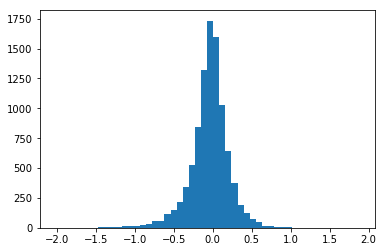

In [68]:
residuals = np.log(y_true) - np.log(y_predict1)
plt.hist(residuals, bins=50);

In [69]:
mean_absolute_error(y_true, y_predict1)

69797.681299294316

In [70]:
median_absolute_error(y_true, y_predict1)

38525.0

In [71]:
y.mean(), y.max(), y.min()

(385268.5836602528, 1740000, 100001)

In [72]:
np.sqrt(mean_squared_error(y_true, y_predict1))

118019.61807144375

In [73]:
y_log = np.log(df1.TotalCost)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.15, random_state=42)

In [75]:
FSM2 = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=0)
FSM2.fit(X_train_log, y_train_log)
y_predict2 = FSM2.predict(X_test_log).astype(int)
y_true_log = y_test_log.as_matrix()
FSM2.score(X_test_log, y_test_log)

0.83328704830532063

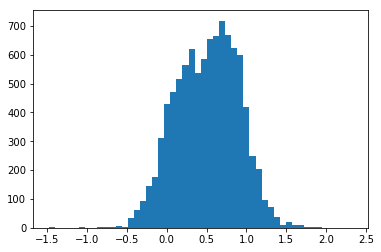

In [76]:
residuals2 = y_true_log - y_predict2
plt.hist(residuals2, bins=50);

In [77]:
median_absolute_error(y_true_log, y_predict2), np.exp(median_absolute_error(y_true_log, y_predict2))

(0.53896706080350221, 1.7142352465785697)

In [78]:
print sum(abs(residuals))/len(y_predict1) # --> Winner is RF with subsected price range
print sum(abs(residuals2))/len(y_predict2)
# print sum(abs(residuals3))/len(y_predict3)
# print sum((residuals4))/len(y_predict4)
print abs(1 - np.exp(sum(abs(residuals))/len(y_predict1)))*100

0.178283807471
0.543355955637
19.5164469712


In [79]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64236 entries, 0 to 71416
Columns: 146 entries, NbrLivingUnits to HeatSystem_8
dtypes: float64(57), int64(33), uint8(56)
memory usage: 50.5 MB


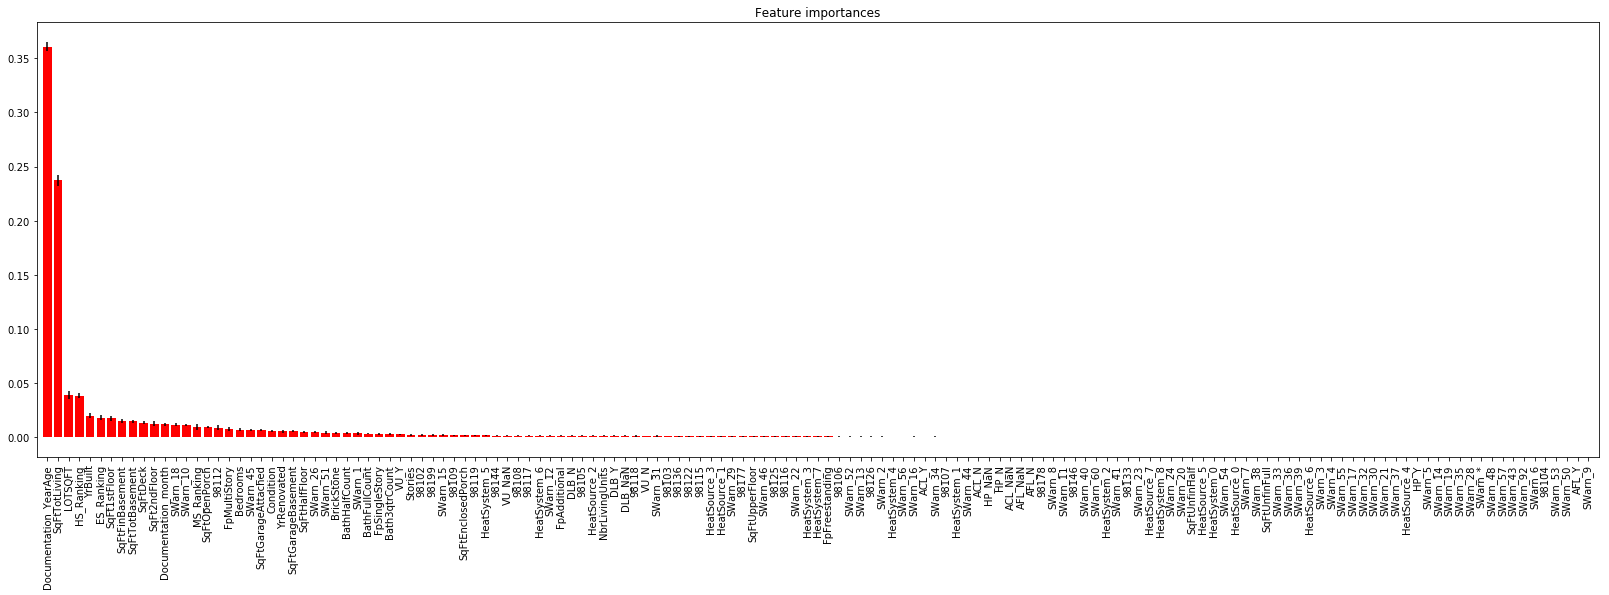

In [80]:
importances = FSM1.feature_importances_
std = np.std([tree.feature_importances_ for tree in FSM1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(28,8))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices],rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show();

In [ ]:
#FSM3 = GradientBoostingRegressor()
#FSM3.fit(X_train, y_train)
#y_predict3 = FSM3.predict(X_test).astype(int)
#FSM3.score(X_test, y_test)

In [ ]:
#residuals3 = np.log(y_true) - np.log(y_predict3)
#plt.hist(residuals3, bins=50);

In [ ]:
#FSM4 = GradientBoostingRegressor()
#FSM4.fit(X_train_log, y_train_log)
#y_predict4 = FSM4.predict(X_test_log).astype(int)
#FSM4.score(X_test_log, y_test_log)

In [ ]:
#residuals4 = y_true_log - y_predict4
#plt.hist(residuals4, bins=50);

In [ ]:
#FSM5 = GradientBoostingRegressor(learning_rate=0.1)
#FSM5.fit(X_train, y_train)
#y_predict5 = FSM5.predict(X_test).astype(int)
#print FSM5.score(X_test, y_test)
#residuals5 = np.log(y_true) - np.log(y_predict5)
#print sum(abs(residuals5))/len(y_predict5)

In [ ]:
#plt.hist(residuals5, bins=50);

In [ ]:
#importances5 = FSM5.feature_importances_
#std5 = np.std([tree.feature_importances_ for tree in FSM5.estimators_],
#            axis=0)
#indices5 = np.argsort(importances5)[::-1]

#plt.figure(figsize=(20,8))
#plt.title("Feature importances")
#plt.bar(range(X.shape[1]), importances5[indices5],
#       color="r", yerr=std5[indices5], align="center")
#plt.xticks(range(X.shape[1]), X.columns[indices5],rotation='vertical')
#plt.xlim([-1, X.shape[1]])
#plt.show();

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}